## Installing package dependencies

In [ ]:
# install the necessary libraries
!pip install --q torch
!pip install --q git+https://github.com/openai/clip
!pip install --q ctransformers[cuda]

  Preparing metadata (setup.py) ... done


## Import the required packages

In [ ]:
## import packages
import requests
import pandas as pd
import cv2
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import clip
import torch
from ctransformers import AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"


## Section 1

### Vector Database creation

Dataset Link: https://huggingface.co/datasets/nateraw/pascal-voc-2012



In [ ]:
# download dataset
_url = """https://huggingface.co/datasets/nateraw/pascal-voc-2012/resolve/main/data/{filename}?download=true"""
fls = ['train-00000-of-00001.parquet', 'val-00000-of-00001.parquet']

for fl in fls:
  response = requests.get(_url.format(filename=fl))

  if response.status_code == 200:
      with open(fl, "wb") as file:
          file.write(response.content)
      print(f"{fl}: File downloaded successfully.")
  else:
      print(f"{fl}: Failed to download the file.")

train-00000-of-00001.parquet: File downloaded successfully.
val-00000-of-00001.parquet: File downloaded successfully.


In [ ]:
# df creation
df = pd.concat([pd.read_parquet(fl, columns=['image']) for fl in fls])
df.head()

,image
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...


In [ ]:
# saving data as images with name as index
os.makedirs('images', exist_ok=True)

imgs_bytes = df.iloc[:, 0].to_list()

for i, img_bytes in tqdm(enumerate(imgs_bytes)):
    np_arr = np.frombuffer(img_bytes['bytes'], np.uint8)
    img = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)          # as cv2 is way faster than PIL in reading and writing images
    cv2.imwrite(f'images/{i}.png', img)


2913it [00:47, 61.24it/s]


In [ ]:
# Create and store the vector database. Feel free to add any helper functions if you need
def create_and_store(data_dir):

  input_images = []
  print('\nPreprocessing images...')
  for i in tqdm(range(df.shape[0])):
    image = Image.open(f"{data_dir}{i}.png")
    input_images.append(preprocess(image).unsqueeze(0).to(device))

  print('\nGenerating embeddings...')
  with torch.no_grad():
    image_embedings = model.encode_image(torch.cat(input_images))
  print("Done.!")

  print('\nSaving embeddings...')
  torch.save(image_embedings, 'image_embeddings.pt')
  print('Done.!')

In [ ]:
data_dir = 'images/'
model, preprocess = clip.load("ViT-B/32", device=device)

create_and_store(data_dir)

100%|███████████████████████████████████████| 338M/338M [00:09<00:00, 39.2MiB/s]



Preprocessing images...


100%|██████████| 2913/2913 [00:29<00:00, 97.93it/s]



Generating embeddings...
Done.!

Saving embeddings...
Done.!


In [ ]:
# Load vectord DB

def loadDB(file_name):
  image_embedings = torch.load(file_name)
  image_embedings = image_embedings.to(device)
  image_embedings = image_embedings / image_embedings.norm(dim=-1, keepdim=True)
  return image_embedings

## Section 2

Implement search functionlity

In [ ]:
# Load vectorDB
filename = 'image_embeddings.pt'
image_embedings = loadDB(filename)

In [ ]:
# Search function

def search(input_query, image_embedings):
  text = clip.tokenize([input_query]).to(device)
  with torch.no_grad():
    text_embedings = model.encode_text(text)

  # similarity
  text_embedings = text_embedings / text_embedings.norm(dim=-1, keepdim=True)
  similarity = (image_embedings @ text_embedings.T).reshape(-1)

  # Get top-n similar images
  values, indices = similarity.topk(1)

  # display image
  fig, axs = plt.subplots(1, 1, figsize=(5, 5))
  img = mpimg.imread(f'images/{indices[0]}.png')
  axs.imshow(img)
  axs.axis('off')

  plt.show()

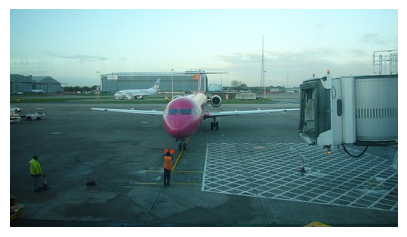

Time taken to search image: 0.144071


In [ ]:
from datetime import datetime

input_query = 'pink airplane'

start1 = datetime.now()
output_image = search(input_query, image_embedings)
print(f"Time taken to search image: {(datetime.now() - start1).total_seconds()}")

In [ ]:
# unload model and data to run llm model

del image_embedings
del model
del preprocess
torch.cuda.empty_cache()


## Section 3

LLM output

In [ ]:
# Load any relevant LLM (You can use huggingface to load and perform other task)
def llm_setup():
        cfg = {'temperature': 0.5,
                'stream': True,
                'max_new_tokens': 160,
                'local_files_only': True
        }

        # Set gpu_layers to the number of layers to offload to GPU. Set to 0 if no GPU acceleration is available on your system.
        llm = AutoModelForCausalLM.from_pretrained("TheBloke/Mistral-7B-Instruct-v0.1-GGUF",
                                                model_file="mistral-7b-instruct-v0.1.Q4_K_M.gguf",
                                                model_type="mistral",
                                                gpu_layers=48,
                                                **cfg)
        return llm


In [ ]:
# Generate the description for the input query

def generate_description(input_query):
  llm_model = llm_setup()
  TEMPLATE = """<s>[INST] You are a friendly chat bot who's willing to provide a brief description of any topic. Please provide a brief description of {user_input} [/INST] </s>"""
  prompt = TEMPLATE.format(user_input=input_query)
  output_text = llm_model(prompt=prompt)
  return output_text

image_embedings = loadDB(filename)
model, preprocess = clip.load("ViT-B/32", device=device)


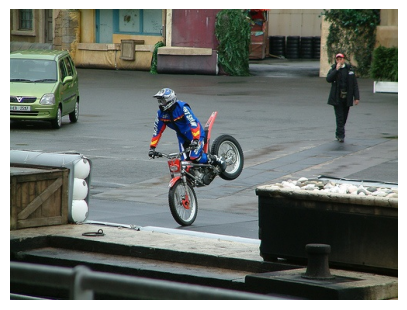

 Bike stunts refer to the act of performing dangerous and thrilling maneuvers on a motorcycle, often involving jumps, flips, and other daring tricks
. These stunts are typically performed by skilled riders who have extensive training and experience in bike handling and safety. They can be seen in professional stunt shows, movies,
 and videos, and are also popular among amateur riders who enjoy pushing their limits and testing their skills. Bike stunts require a high level of skill, precision, and
 control, as well as a deep understanding of bike mechanics and physics.

In [ ]:
input_query = 'Bike stunt'

search(input_query, image_embedings)
del (image_embedings, model)        # to unload gpu
for i, text in enumerate(generate_description(input_query)): # as streaming is True, the function will act as a generator
    print(text, end='')
    if (i+1)%35 == 0:
      print()